In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

# --- Environment Setup ---y

# Option 1: Using Anaconda
# conda create --name tf python=3.8 anaconda 
# conda activate tf
# pip install -r ../requirements.txt
# Note: This installs an older version of TensorFlow since Anaconda 
# no longer maintains recent GPU packages. It still works reliably.

# Option 2: Using Python venv
# python3 -m venv .venv
# source .venv/bin/activate
# pip install -r ../requirements.txt

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import utils as np_utils
from fMRINet import fmriNet8, fmriNet16, fmriNet32

import sklearn
import tensorflow as tf

# TensorFlow optimizers

# AdamW lives in different places depending on TF version.
try:
    # TF ≥ 2.13
    from tensorflow.keras.optimizers import AdamW
except ImportError:
    try:
        # TF 2.11–2.12
        from tensorflow.keras.optimizers.experimental import AdamW
    except ImportError:
        # TF 2.10.x (requires tensorflow-addons)
        from tensorflow_addons.optimizers import AdamW

# For compatibility with libraries such as iNNvestigate, 
# you may need to disable eager execution:
# tf.compat.v1.disable_eager_execution()

In [2]:
# Load the DataFrame from the pickle file /-/ this is the toy dataframe ; for the actual data; please consider dataframe.pkl and get in touch with the author.


# #{'PVT': 0, 'VWM': 1, 'DOT': 2, 'MOD': 3, 'DYN': 4, 'rest': 5}
# df = pd.read_pickle('dataframe.pkl')

# df.head()


#{'PVT': 0, 'VWM': 1, 'DOT': 2, 'MOD': 3, 'DYN': 4, 'rest': 5}
df = pd.read_pickle('dataframe.pkl')

df.head()

,Task,Time_Series_Data,subject,session
0,0,"[[1.9457951942054184, 2.1243432446451473, 2.24...",2755j,4
1,0,"[[2.0062126993459035, 1.1112578943817553, 2.87...",2755j,4
3,1,"[[3.1558751679308363, 1.7991844301841418, 2.59...",1043f,3
5,1,"[[1.779440351375669, 1.7387005028929754, 2.338...",4558a,1
7,2,"[[0.11108687476175652, 1.7908513499100132, 0.4...",4662a,8


In [3]:
print("TF version:", tf.__version__)
print("Built with CUDA?", tf.test.is_built_with_cuda())
print("Visible GPUs:", tf.config.list_physical_devices("GPU"))

TF version: 2.19.1
Built with CUDA? False
Visible GPUs: []


In [4]:
# subjs = df["subject"].unique()
# np.random.shuffle(subjs) # do in-place shuffle

# to work with the same train/validation splits while doing model development
with open('subjs.pickle', 'rb') as f:
    subjs = pickle.load(f)

# pull train/valid data by taking subjects from shuffled list
train_df = df[df['subject'].isin(subjs[0:45])]
valid_df = df[df['subject'].isin(subjs[45:,])]

# convert to numpy arrays and do reordering of data dimensions to feed into network
train_label = np.array(train_df['Task'])

train_data  = np.dstack(train_df['Time_Series_Data'])
train_data  = np.expand_dims(train_data, axis=0)
train_data  = np.transpose(train_data, axes=[3, 2, 1, 0]) # (batch, row, time, region)

valid_label = np.array(valid_df['Task'])

valid_data  = np.dstack(valid_df['Time_Series_Data'])
valid_data  = np.expand_dims(valid_data, axis=0)
valid_data  = np.transpose(valid_data, axes=[3, 2, 1, 0]) # (batch, row, time, region)

In [5]:
train_label = np_utils.to_categorical(train_label)
valid_label = np_utils.to_categorical(valid_label)


In [6]:
# calculate class weights for training data to use at training time
train_label_v2 = np.argmax(train_label, axis=1)
a, b           = np.unique(train_label_v2, return_counts=True)
weights        = sklearn.utils.class_weight.compute_class_weight(class_weight='balanced', classes=a, y=train_label_v2)
class_weights  = {0:weights[0], 1:weights[1], 2:weights[2], 3:weights[3], 4:weights[4], 5:weights[5]}
class_weights

{0: np.float64(1.3031135531135531),
 1: np.float64(0.8800247371675943),
 2: np.float64(1.2417102966841187),
 3: np.float64(0.9139370584457289),
 4: np.float64(0.568063872255489),
 5: np.float64(2.2914653784219)}

In [7]:
model = fmriNet8(num_classes=6, input_shape=(214, 277, 1), temporal_kernel_sec=60, fs=1.0)  # or fmriNet16(), fmriNet32()

model.summary()

Model: "fmriNet8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 214, 277, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 214, 277, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 214, 277, 8)    │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute (Permute)               │ (None, 277, 214, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 277, 1, 32)     │         6,848 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 277, 1, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 277, 1, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute_1 (Permute)             │ (None, 1, 277, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 1, 18, 32)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 18, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 1, 18, 64)      │         2,304 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 18, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1, 18, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 1, 4, 64)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         1,542 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Activation)            │ (None, 6)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,558 (45.15 KB)

 Trainable params: 11,366 (44.40 KB)

 Non-trainable params: 192 (768.00 B)

In [8]:
model.compile(loss='categorical_crossentropy', optimizer=AdamW(weight_decay=0.0005), 
              metrics = ['accuracy'])

checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1,
                               save_best_only=True)

# simple learning rate schedule, half learning rate every 200 epochs
# which seems to do ok for this data
def lr_schedule(epoch):
         return (0.001 * np.power(0.5, np.floor(epoch/200)))

scheduler    = LearningRateScheduler(lr_schedule, verbose=1)

In [9]:
# without eager execution this takes much longer to train..
fittedModel = model.fit(train_data, train_label, batch_size = 64, epochs = 100, 
                        verbose = 2, validation_data=(valid_data, valid_label),
                        callbacks=[checkpointer], class_weight = class_weights)

Epoch 1/100

Epoch 1: val_loss improved from None to 1.79312, saving model to /tmp/checkpoint.h5


45/45 - 14s - 310ms/step - accuracy: 0.1662 - loss: 2.0254 - val_accuracy: 0.1252 - val_loss: 1.7931
Epoch 2/100

Epoch 2: val_loss improved from 1.79312 to 1.78852, saving model to /tmp/checkpoint.h5


45/45 - 13s - 281ms/step - accuracy: 0.1831 - loss: 1.9149 - val_accuracy: 0.1972 - val_loss: 1.7885
Epoch 3/100

Epoch 3: val_loss improved from 1.78852 to 1.78335, saving model to /tmp/checkpoint.h5


45/45 - 13s - 295ms/step - accuracy: 0.2070 - loss: 1.8811 - val_accuracy: 0.2175 - val_loss: 1.7833
Epoch 4/100

Epoch 4: val_loss improved from 1.78335 to 1.73768, saving model to /tmp/checkpoint.h5


45/45 - 14s - 300ms/step - accuracy: 0.2277 - loss: 1.8048 - val_accuracy: 0.3052 - val_loss: 1.7377
Epoch 5/100

Epoch 5: val_loss improved from 1.73768 to 1.62369, saving model to /tmp/checkpoint.h5


45/45 - 13s - 287ms/step - accuracy: 0.2990 - loss: 1.6664 - val_accuracy: 0.3396 - val_loss: 1.6237
Epoch 6/100

Epoch 6: val_loss improved from 1.62369 to 1.55309, saving model to /tmp/checkpoint.h5


45/45 - 13s - 290ms/step - accuracy: 0.3289 - loss: 1.5846 - val_accuracy: 0.4116 - val_loss: 1.5531
Epoch 7/100

Epoch 7: val_loss improved from 1.55309 to 1.48629, saving model to /tmp/checkpoint.h5


45/45 - 13s - 290ms/step - accuracy: 0.3377 - loss: 1.5507 - val_accuracy: 0.4679 - val_loss: 1.4863
Epoch 8/100

Epoch 8: val_loss improved from 1.48629 to 1.42320, saving model to /tmp/checkpoint.h5


45/45 - 13s - 294ms/step - accuracy: 0.3844 - loss: 1.4957 - val_accuracy: 0.4836 - val_loss: 1.4232
Epoch 9/100

Epoch 9: val_loss improved from 1.42320 to 1.34400, saving model to /tmp/checkpoint.h5


45/45 - 13s - 294ms/step - accuracy: 0.3985 - loss: 1.4189 - val_accuracy: 0.5070 - val_loss: 1.3440
Epoch 10/100

Epoch 10: val_loss improved from 1.34400 to 1.30675, saving model to /tmp/checkpoint.h5


45/45 - 13s - 292ms/step - accuracy: 0.4469 - loss: 1.3573 - val_accuracy: 0.4898 - val_loss: 1.3068
Epoch 11/100

Epoch 11: val_loss improved from 1.30675 to 1.24400, saving model to /tmp/checkpoint.h5


45/45 - 13s - 293ms/step - accuracy: 0.4684 - loss: 1.3088 - val_accuracy: 0.5196 - val_loss: 1.2440
Epoch 12/100

Epoch 12: val_loss improved from 1.24400 to 1.14307, saving model to /tmp/checkpoint.h5


45/45 - 13s - 294ms/step - accuracy: 0.4891 - loss: 1.2591 - val_accuracy: 0.6213 - val_loss: 1.1431
Epoch 13/100

Epoch 13: val_loss did not improve from 1.14307
45/45 - 13s - 294ms/step - accuracy: 0.5172 - loss: 1.2022 - val_accuracy: 0.5540 - val_loss: 1.1551
Epoch 14/100

Epoch 14: val_loss improved from 1.14307 to 1.06783, saving model to /tmp/checkpoint.h5


45/45 - 13s - 293ms/step - accuracy: 0.5214 - loss: 1.1852 - val_accuracy: 0.6213 - val_loss: 1.0678
Epoch 15/100

Epoch 15: val_loss improved from 1.06783 to 1.06000, saving model to /tmp/checkpoint.h5


45/45 - 13s - 291ms/step - accuracy: 0.5362 - loss: 1.1489 - val_accuracy: 0.6056 - val_loss: 1.0600
Epoch 16/100

Epoch 16: val_loss improved from 1.06000 to 0.99331, saving model to /tmp/checkpoint.h5


45/45 - 13s - 294ms/step - accuracy: 0.5404 - loss: 1.1233 - val_accuracy: 0.6573 - val_loss: 0.9933
Epoch 17/100

Epoch 17: val_loss improved from 0.99331 to 0.93062, saving model to /tmp/checkpoint.h5


45/45 - 13s - 294ms/step - accuracy: 0.5517 - loss: 1.1020 - val_accuracy: 0.6870 - val_loss: 0.9306
Epoch 18/100

Epoch 18: val_loss improved from 0.93062 to 0.91963, saving model to /tmp/checkpoint.h5


45/45 - 13s - 290ms/step - accuracy: 0.5601 - loss: 1.0759 - val_accuracy: 0.6901 - val_loss: 0.9196
Epoch 19/100

Epoch 19: val_loss improved from 0.91963 to 0.86110, saving model to /tmp/checkpoint.h5


45/45 - 14s - 321ms/step - accuracy: 0.5833 - loss: 1.0484 - val_accuracy: 0.7199 - val_loss: 0.8611
Epoch 20/100

Epoch 20: val_loss did not improve from 0.86110
45/45 - 15s - 324ms/step - accuracy: 0.5826 - loss: 1.0317 - val_accuracy: 0.7121 - val_loss: 0.8635
Epoch 21/100

Epoch 21: val_loss improved from 0.86110 to 0.84350, saving model to /tmp/checkpoint.h5


45/45 - 15s - 331ms/step - accuracy: 0.5808 - loss: 1.0283 - val_accuracy: 0.7214 - val_loss: 0.8435
Epoch 22/100

Epoch 22: val_loss improved from 0.84350 to 0.81696, saving model to /tmp/checkpoint.h5


45/45 - 16s - 346ms/step - accuracy: 0.5970 - loss: 1.0054 - val_accuracy: 0.7371 - val_loss: 0.8170
Epoch 23/100

Epoch 23: val_loss improved from 0.81696 to 0.80122, saving model to /tmp/checkpoint.h5


45/45 - 15s - 338ms/step - accuracy: 0.6096 - loss: 0.9865 - val_accuracy: 0.7543 - val_loss: 0.8012
Epoch 24/100

Epoch 24: val_loss did not improve from 0.80122
45/45 - 15s - 338ms/step - accuracy: 0.6110 - loss: 0.9672 - val_accuracy: 0.7324 - val_loss: 0.8205
Epoch 25/100

Epoch 25: val_loss improved from 0.80122 to 0.78148, saving model to /tmp/checkpoint.h5


45/45 - 15s - 340ms/step - accuracy: 0.6128 - loss: 0.9508 - val_accuracy: 0.7590 - val_loss: 0.7815
Epoch 26/100

Epoch 26: val_loss did not improve from 0.78148
45/45 - 15s - 335ms/step - accuracy: 0.6240 - loss: 0.9562 - val_accuracy: 0.7574 - val_loss: 0.7927
Epoch 27/100

Epoch 27: val_loss improved from 0.78148 to 0.78066, saving model to /tmp/checkpoint.h5


45/45 - 15s - 339ms/step - accuracy: 0.6328 - loss: 0.9301 - val_accuracy: 0.7653 - val_loss: 0.7807
Epoch 28/100

Epoch 28: val_loss improved from 0.78066 to 0.74839, saving model to /tmp/checkpoint.h5


45/45 - 15s - 340ms/step - accuracy: 0.6497 - loss: 0.9168 - val_accuracy: 0.7559 - val_loss: 0.7484
Epoch 29/100

Epoch 29: val_loss improved from 0.74839 to 0.73410, saving model to /tmp/checkpoint.h5


45/45 - 15s - 337ms/step - accuracy: 0.6500 - loss: 0.9061 - val_accuracy: 0.7809 - val_loss: 0.7341
Epoch 30/100

Epoch 30: val_loss improved from 0.73410 to 0.72773, saving model to /tmp/checkpoint.h5


45/45 - 15s - 340ms/step - accuracy: 0.6616 - loss: 0.8809 - val_accuracy: 0.7731 - val_loss: 0.7277
Epoch 31/100

Epoch 31: val_loss did not improve from 0.72773
45/45 - 15s - 335ms/step - accuracy: 0.6602 - loss: 0.8968 - val_accuracy: 0.7825 - val_loss: 0.7315
Epoch 32/100

Epoch 32: val_loss improved from 0.72773 to 0.71494, saving model to /tmp/checkpoint.h5


45/45 - 15s - 337ms/step - accuracy: 0.6574 - loss: 0.8862 - val_accuracy: 0.7856 - val_loss: 0.7149
Epoch 33/100

Epoch 33: val_loss did not improve from 0.71494
45/45 - 15s - 337ms/step - accuracy: 0.6641 - loss: 0.8709 - val_accuracy: 0.7872 - val_loss: 0.7246
Epoch 34/100

Epoch 34: val_loss improved from 0.71494 to 0.70241, saving model to /tmp/checkpoint.h5


45/45 - 15s - 337ms/step - accuracy: 0.6753 - loss: 0.8697 - val_accuracy: 0.7981 - val_loss: 0.7024
Epoch 35/100

Epoch 35: val_loss improved from 0.70241 to 0.68415, saving model to /tmp/checkpoint.h5


45/45 - 15s - 331ms/step - accuracy: 0.6634 - loss: 0.8499 - val_accuracy: 0.8013 - val_loss: 0.6842
Epoch 36/100

Epoch 36: val_loss did not improve from 0.68415
45/45 - 13s - 293ms/step - accuracy: 0.6648 - loss: 0.8621 - val_accuracy: 0.7950 - val_loss: 0.6870
Epoch 37/100

Epoch 37: val_loss did not improve from 0.68415
45/45 - 13s - 288ms/step - accuracy: 0.6757 - loss: 0.8368 - val_accuracy: 0.7840 - val_loss: 0.7040
Epoch 38/100

Epoch 38: val_loss improved from 0.68415 to 0.67944, saving model to /tmp/checkpoint.h5


45/45 - 13s - 288ms/step - accuracy: 0.6557 - loss: 0.8726 - val_accuracy: 0.7950 - val_loss: 0.6794
Epoch 39/100

Epoch 39: val_loss did not improve from 0.67944
45/45 - 13s - 289ms/step - accuracy: 0.6869 - loss: 0.8212 - val_accuracy: 0.7840 - val_loss: 0.7001
Epoch 40/100

Epoch 40: val_loss did not improve from 0.67944
45/45 - 13s - 288ms/step - accuracy: 0.6774 - loss: 0.8317 - val_accuracy: 0.7934 - val_loss: 0.6815
Epoch 41/100

Epoch 41: val_loss did not improve from 0.67944
45/45 - 13s - 287ms/step - accuracy: 0.6869 - loss: 0.8222 - val_accuracy: 0.7840 - val_loss: 0.6873
Epoch 42/100

Epoch 42: val_loss improved from 0.67944 to 0.67937, saving model to /tmp/checkpoint.h5


45/45 - 13s - 290ms/step - accuracy: 0.7017 - loss: 0.8048 - val_accuracy: 0.7934 - val_loss: 0.6794
Epoch 43/100

Epoch 43: val_loss improved from 0.67937 to 0.66137, saving model to /tmp/checkpoint.h5


45/45 - 13s - 290ms/step - accuracy: 0.6897 - loss: 0.7972 - val_accuracy: 0.7997 - val_loss: 0.6614
Epoch 44/100

Epoch 44: val_loss improved from 0.66137 to 0.65727, saving model to /tmp/checkpoint.h5


45/45 - 13s - 287ms/step - accuracy: 0.7034 - loss: 0.7850 - val_accuracy: 0.8059 - val_loss: 0.6573
Epoch 45/100

Epoch 45: val_loss improved from 0.65727 to 0.65234, saving model to /tmp/checkpoint.h5


45/45 - 13s - 288ms/step - accuracy: 0.6933 - loss: 0.8025 - val_accuracy: 0.7966 - val_loss: 0.6523
Epoch 46/100

Epoch 46: val_loss did not improve from 0.65234
45/45 - 13s - 288ms/step - accuracy: 0.7031 - loss: 0.8006 - val_accuracy: 0.8013 - val_loss: 0.6583
Epoch 47/100

Epoch 47: val_loss improved from 0.65234 to 0.64101, saving model to /tmp/checkpoint.h5


45/45 - 13s - 292ms/step - accuracy: 0.6961 - loss: 0.7745 - val_accuracy: 0.8091 - val_loss: 0.6410
Epoch 48/100

Epoch 48: val_loss did not improve from 0.64101
45/45 - 13s - 289ms/step - accuracy: 0.6876 - loss: 0.7795 - val_accuracy: 0.7950 - val_loss: 0.6537
Epoch 49/100

Epoch 49: val_loss improved from 0.64101 to 0.63950, saving model to /tmp/checkpoint.h5


45/45 - 13s - 284ms/step - accuracy: 0.6999 - loss: 0.7838 - val_accuracy: 0.8091 - val_loss: 0.6395
Epoch 50/100

Epoch 50: val_loss improved from 0.63950 to 0.63831, saving model to /tmp/checkpoint.h5


45/45 - 13s - 286ms/step - accuracy: 0.7020 - loss: 0.7855 - val_accuracy: 0.8044 - val_loss: 0.6383
Epoch 51/100

Epoch 51: val_loss did not improve from 0.63831
45/45 - 13s - 290ms/step - accuracy: 0.6992 - loss: 0.7654 - val_accuracy: 0.7981 - val_loss: 0.6635
Epoch 52/100

Epoch 52: val_loss did not improve from 0.63831
45/45 - 13s - 286ms/step - accuracy: 0.7059 - loss: 0.7575 - val_accuracy: 0.7950 - val_loss: 0.6630
Epoch 53/100

Epoch 53: val_loss did not improve from 0.63831
45/45 - 13s - 290ms/step - accuracy: 0.6996 - loss: 0.7945 - val_accuracy: 0.7887 - val_loss: 0.6670
Epoch 54/100

Epoch 54: val_loss improved from 0.63831 to 0.63806, saving model to /tmp/checkpoint.h5


45/45 - 13s - 286ms/step - accuracy: 0.7122 - loss: 0.7737 - val_accuracy: 0.7997 - val_loss: 0.6381
Epoch 55/100

Epoch 55: val_loss did not improve from 0.63806
45/45 - 13s - 289ms/step - accuracy: 0.7066 - loss: 0.7677 - val_accuracy: 0.8075 - val_loss: 0.6398
Epoch 56/100

Epoch 56: val_loss improved from 0.63806 to 0.63474, saving model to /tmp/checkpoint.h5


45/45 - 13s - 289ms/step - accuracy: 0.7175 - loss: 0.7447 - val_accuracy: 0.8138 - val_loss: 0.6347
Epoch 57/100

Epoch 57: val_loss improved from 0.63474 to 0.62716, saving model to /tmp/checkpoint.h5


45/45 - 14s - 317ms/step - accuracy: 0.6936 - loss: 0.7865 - val_accuracy: 0.8138 - val_loss: 0.6272
Epoch 58/100

Epoch 58: val_loss did not improve from 0.62716
45/45 - 15s - 323ms/step - accuracy: 0.7080 - loss: 0.7436 - val_accuracy: 0.8059 - val_loss: 0.6451
Epoch 59/100

Epoch 59: val_loss did not improve from 0.62716
45/45 - 15s - 326ms/step - accuracy: 0.7045 - loss: 0.7643 - val_accuracy: 0.8044 - val_loss: 0.6382
Epoch 60/100

Epoch 60: val_loss did not improve from 0.62716
45/45 - 15s - 326ms/step - accuracy: 0.7066 - loss: 0.7464 - val_accuracy: 0.8044 - val_loss: 0.6439
Epoch 61/100

Epoch 61: val_loss did not improve from 0.62716
45/45 - 14s - 316ms/step - accuracy: 0.7091 - loss: 0.7621 - val_accuracy: 0.8106 - val_loss: 0.6333
Epoch 62/100

Epoch 62: val_loss improved from 0.62716 to 0.61647, saving model to /tmp/checkpoint.h5


45/45 - 13s - 288ms/step - accuracy: 0.7112 - loss: 0.7546 - val_accuracy: 0.8185 - val_loss: 0.6165
Epoch 63/100

Epoch 63: val_loss did not improve from 0.61647
45/45 - 13s - 286ms/step - accuracy: 0.7175 - loss: 0.7352 - val_accuracy: 0.8138 - val_loss: 0.6318
Epoch 64/100

Epoch 64: val_loss did not improve from 0.61647
45/45 - 13s - 287ms/step - accuracy: 0.7080 - loss: 0.7446 - val_accuracy: 0.8091 - val_loss: 0.6182
Epoch 65/100

Epoch 65: val_loss did not improve from 0.61647
45/45 - 13s - 286ms/step - accuracy: 0.7200 - loss: 0.7334 - val_accuracy: 0.8044 - val_loss: 0.6317
Epoch 66/100

Epoch 66: val_loss did not improve from 0.61647
45/45 - 13s - 289ms/step - accuracy: 0.7164 - loss: 0.7259 - val_accuracy: 0.8044 - val_loss: 0.6264
Epoch 67/100

Epoch 67: val_loss did not improve from 0.61647
45/45 - 13s - 287ms/step - accuracy: 0.7136 - loss: 0.7358 - val_accuracy: 0.8075 - val_loss: 0.6262
Epoch 68/100

Epoch 68: val_loss did not improve from 0.61647
45/45 - 13s - 288ms/st

45/45 - 13s - 293ms/step - accuracy: 0.7252 - loss: 0.7078 - val_accuracy: 0.8169 - val_loss: 0.6119
Epoch 76/100

Epoch 76: val_loss did not improve from 0.61190
45/45 - 13s - 293ms/step - accuracy: 0.7407 - loss: 0.6939 - val_accuracy: 0.8153 - val_loss: 0.6198
Epoch 77/100

Epoch 77: val_loss did not improve from 0.61190
45/45 - 13s - 290ms/step - accuracy: 0.7112 - loss: 0.7314 - val_accuracy: 0.8169 - val_loss: 0.6231
Epoch 78/100

Epoch 78: val_loss did not improve from 0.61190
45/45 - 13s - 285ms/step - accuracy: 0.7182 - loss: 0.7010 - val_accuracy: 0.8091 - val_loss: 0.6292
Epoch 79/100

Epoch 79: val_loss did not improve from 0.61190
45/45 - 13s - 286ms/step - accuracy: 0.7210 - loss: 0.7302 - val_accuracy: 0.8044 - val_loss: 0.6476
Epoch 80/100

Epoch 80: val_loss did not improve from 0.61190
45/45 - 14s - 306ms/step - accuracy: 0.7277 - loss: 0.7019 - val_accuracy: 0.7981 - val_loss: 0.6412
Epoch 81/100

Epoch 81: val_loss did not improve from 0.61190
45/45 - 15s - 335ms/st

45/45 - 15s - 335ms/step - accuracy: 0.7189 - loss: 0.7079 - val_accuracy: 0.8122 - val_loss: 0.6035
Epoch 84/100

Epoch 84: val_loss did not improve from 0.60349
45/45 - 15s - 341ms/step - accuracy: 0.7154 - loss: 0.7101 - val_accuracy: 0.8059 - val_loss: 0.6217
Epoch 85/100

Epoch 85: val_loss did not improve from 0.60349
45/45 - 16s - 353ms/step - accuracy: 0.7235 - loss: 0.7115 - val_accuracy: 0.8122 - val_loss: 0.6124
Epoch 86/100

Epoch 86: val_loss did not improve from 0.60349
45/45 - 16s - 347ms/step - accuracy: 0.7354 - loss: 0.6979 - val_accuracy: 0.8106 - val_loss: 0.6174
Epoch 87/100

Epoch 87: val_loss did not improve from 0.60349
45/45 - 16s - 345ms/step - accuracy: 0.7375 - loss: 0.7021 - val_accuracy: 0.7981 - val_loss: 0.6255
Epoch 88/100

Epoch 88: val_loss did not improve from 0.60349
45/45 - 15s - 338ms/step - accuracy: 0.7287 - loss: 0.7054 - val_accuracy: 0.8028 - val_loss: 0.6320
Epoch 89/100

Epoch 89: val_loss did not improve from 0.60349
45/45 - 15s - 339ms/st

45/45 - 15s - 338ms/step - accuracy: 0.7340 - loss: 0.6950 - val_accuracy: 0.8279 - val_loss: 0.5990
Epoch 99/100

Epoch 99: val_loss improved from 0.59897 to 0.58932, saving model to /tmp/checkpoint.h5


45/45 - 15s - 341ms/step - accuracy: 0.7309 - loss: 0.6952 - val_accuracy: 0.8326 - val_loss: 0.5893
Epoch 100/100

Epoch 100: val_loss did not improve from 0.58932
45/45 - 15s - 337ms/step - accuracy: 0.7186 - loss: 0.7058 - val_accuracy: 0.8106 - val_loss: 0.6131


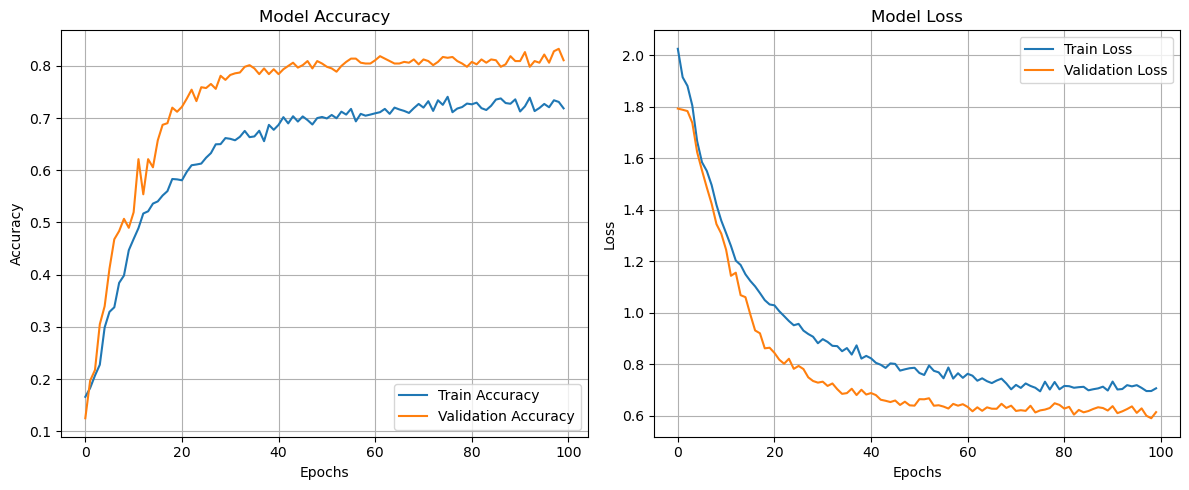

In [10]:
# Plot training history
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(fittedModel.history['accuracy'], label='Train Accuracy')
plt.plot(fittedModel.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(fittedModel.history['loss'], label='Train Loss')
plt.plot(fittedModel.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [11]:
model.load_weights('/tmp/checkpoint.h5')
preds = model.predict(valid_data)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [12]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(np.argmax(valid_label, axis=1), np.argmax(preds, axis=1))

0.8121167463423467

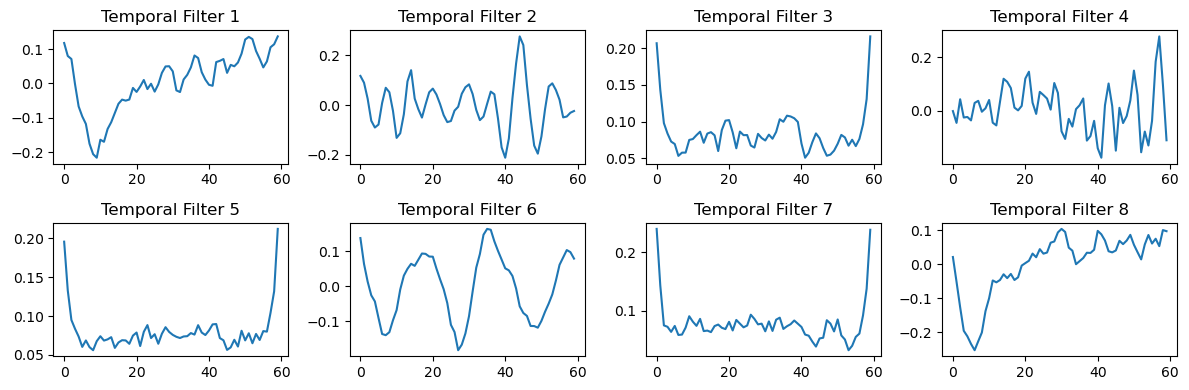

In [13]:
filters = np.squeeze(model.layers[2].get_weights())

fig = plt.subplots(2, 4, figsize=(12, 4))

for i in range(1, 9):
    plt.subplot(2, 4, i)
    plt.plot(filters[:, i-1])
    plt.title(f'Temporal Filter {i}')
    
plt.tight_layout()

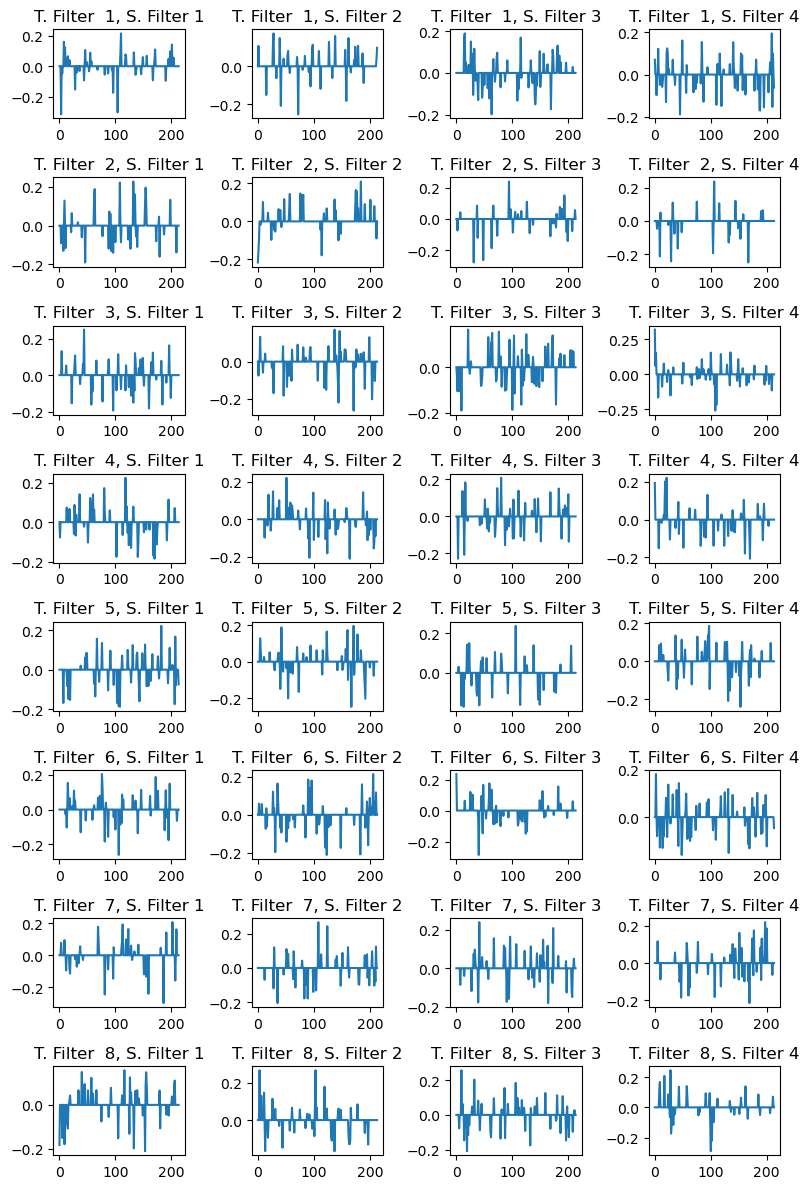

In [14]:
filters = np.squeeze(model.layers[4].get_weights())

fig = plt.subplots(8, 4, figsize=(8, 12))

i = 1
for j in range(8):
    for k in range(4):
        plt.subplot(8, 4, i)
        plt.plot(filters[:, j, k])
        plt.title(f'T. Filter  {j+1}, S. Filter {k+1}')
        i = i + 1
    
plt.tight_layout()